In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os, sys
import math
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import random


In [12]:
# right knee and left shoulder and right-ankle

IMAGE_SIZE = 128
NUM_CLASSES = 12
STD_DEV = 15  # alwaysd keep odd
DATASET_PATH = "/content/drive/Shareddrives/DLNN_ProjF/data/stage2_updated.csv"
IMAGES_DIR = "/content/drive/Shareddrives/DLNN_ProjF/data/mpii_human_pose/images"
DATASET_SAVE_PATH = "/content/drive/Shareddrives/DLNN_ProjF/data/unaugmented_final_data"

BATCH_SIZE = 1000

CIRCLE_RADIUS = 21
AUGMENTATION_FACTOR = 0

CLASS_NUMBERS = {
    "left_wrist" : 0,
    "left_elbow" : 1,
    "left_shoulder" : 2,
    "left_hip" : 3,
    "left_knee" : 4,
    "left_ankle" : 5,
    "right_wrist" : 6,
    "right_elbow" : 7,
    "right_shoulder" : 8,
    "right_hip" : 9,
    "right_knee" : 10,
    "right_ankle" : 11    
}

In [13]:
## below cells are required only for loading the data for the first time

# reading the data-frame
dataset_df = pd.read_csv(DATASET_PATH)

single_person_filenames = dataset_df.filename.value_counts()
single_person_filenames =single_person_filenames[single_person_filenames == 1]
# single_person_filenames

dataset_df = dataset_df[dataset_df.filename.isin(single_person_filenames.index)]
dataset_df = dataset_df.reset_index()

print("Number rows:", dataset_df.shape[0])

Number rows: 2523


In [14]:
# install augmentation library
!pip install imgaug

In [15]:
#  define the augmenters

import imgaug as ia
import imgaug.augmenters as iaa


sd = 33 #since we are Group 33 

affine_augmenter_img = iaa.Sequential(
    [iaa.Affine( scale={"x": (0.95, 1.05), "y": (0.95, 1.05)}, translate_percent =(0.1), rotate = (-5,5), mode=["edge"], fit_output = False),
    iaa.Fliplr(0.5),
    ], random_order = True)

affine_augmenter_msk = iaa.Sequential(
    [iaa.Affine( scale={"x": (0.95, 1.05), "y": (0.95, 1.05)}, translate_percent =(0.1), rotate = (-5,5), mode=["constant"], fit_output = False, cval = 0),
    iaa.Fliplr(0.5),
    ], random_order = True)

ia.seed(sd)
det_affine_img = affine_augmenter_img.to_deterministic()
ia.seed(sd)
det_affine_msk = affine_augmenter_msk.to_deterministic()

Starting batch_number: 0


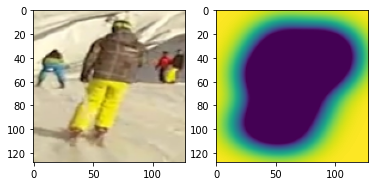

[21.24074178]


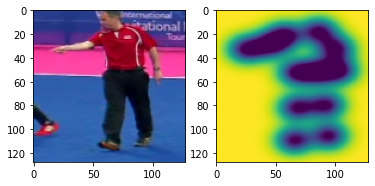

[9.39988526]


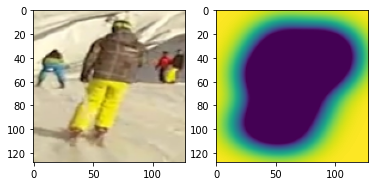

[21.24074178]


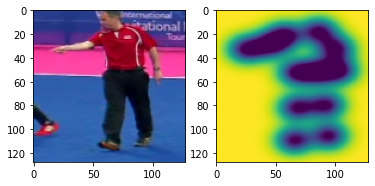

[9.39988526]
Finished batch_number: 0
Rows proessesed: 1000
Useful images found: 997
Out of them, train: 798
Out of them, test: 199
Starting batch_number: 1


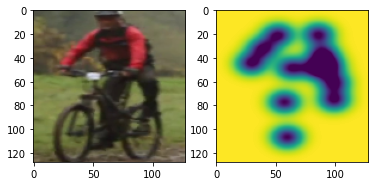

[9.76088346]


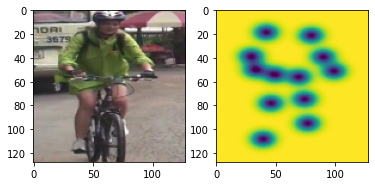

[7.1500632]


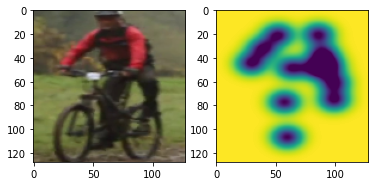

[9.76088346]


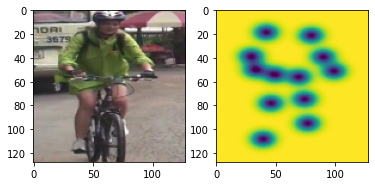

[7.1500632]
Finished batch_number: 1
Rows proessesed: 2000
Useful images found: 996
Out of them, train: 797
Out of them, test: 199
Starting batch_number: 2


KeyError: ignored

In [16]:
#this batched data-processing is required because the dataset is too big to fit into RAM

done_rows = 0
for batch_number in range((dataset_df.shape[0] // BATCH_SIZE)+1):
  print("Starting batch_number:", batch_number)

  if done_rows > dataset_df.shape[0]:
    print("All data processed; Terminating the last batch")
    break

  #creating place_holders for this batch
  images = np.zeros(shape = (1, IMAGE_SIZE, IMAGE_SIZE, 3), dtype= float)
  heatmaps = np.zeros(shape = (1, IMAGE_SIZE, IMAGE_SIZE, NUM_CLASSES + 1), dtype= float)
  headlengths = np.zeros(shape = (1, 1), dtype = float)


  for i in range(done_rows, done_rows+BATCH_SIZE):
    #checking if image exists
    if os.path.exists(os.path.join(IMAGES_DIR, dataset_df.filename[i])):
        
      # extracting meta-data from the data-frame
      filename = dataset_df.filename[i]
      xmin = int(dataset_df.x_min[i])
      xmax = int(dataset_df.x_max[i])
      
      ymin = int(dataset_df.y_min[i])
      ymax = int(dataset_df.y_max[i])
      
      # calculating new headlength and inserting it into place-holder
      headlength = dataset_df.head_length[i]*(IMAGE_SIZE*IMAGE_SIZE)/((xmax-xmin)*(ymax-ymin))
      headlengths = np.concatenate((headlengths, np.expand_dims(np.array([headlength], dtype = float), axis = 0)), axis = 0)

      # getting all key-point co-ordinates
      right_shoulder_x, right_shoulder_y = int(dataset_df.joint_pos_r_shoulder_x[i]), int(dataset_df.joint_pos_r_shoulder_y[i])
      left_shoulder_x, left_shoulder_y = int(dataset_df.joint_pos_l_shoulder_x[i]), int(dataset_df.joint_pos_l_shoulder_y[i])

      right_knee_x, right_knee_y = int(dataset_df.joint_pos_r_knee_x[i]), int(dataset_df.joint_pos_r_knee_y[i])
      left_knee_x, left_knee_y = int(dataset_df.joint_pos_l_knee_x[i]), int(dataset_df.joint_pos_l_knee_y[i])
      
      right_ankle_x, right_ankle_y = int(dataset_df.joint_pos_r_ankle_x[i]), int(dataset_df.joint_pos_r_ankle_y[i])
      left_ankle_x, left_ankle_y = int(dataset_df.joint_pos_l_ankle_x[i]), int(dataset_df.joint_pos_l_ankle_y[i])
      
      right_hip_x, right_hip_y = int(dataset_df.joint_pos_r_hip_x[i]), int(dataset_df.joint_pos_r_hip_y[i])
      left_hip_x, left_hip_y = int(dataset_df.joint_pos_l_hip_x[i]), int(dataset_df.joint_pos_l_hip_y[i])
      
      right_wrist_x, right_wrist_y = int(dataset_df.joint_pos_r_wrist_x[i]), int(dataset_df.joint_pos_r_wrist_y[i])
      left_wrist_x, left_wrist_y = int(dataset_df.joint_pos_l_wrist_x[i]), int(dataset_df.joint_pos_l_wrist_y[i])
      
      right_elbow_x, right_elbow_y = int(dataset_df.joint_pos_r_elbow_x[i]), int(dataset_df.joint_pos_r_elbow_y[i])
      left_elbow_x, left_elbow_y = int(dataset_df.joint_pos_l_elbow_x[i]), int(dataset_df.joint_pos_l_elbow_y[i])



      # reading the image
      temp = cv2.imread(os.path.join(IMAGES_DIR, filename))
      
      # ropping out the area of intrest
      temp[:, :xmin, :] = 0
      temp[:, xmax:, :] = 0
      temp[:ymin, :, :] = 0
      temp[ymax:,:, :] = 0
      temp = temp[ymin:ymax, xmin:xmax]


      # Generating the KP heatmaps
      labels = np.zeros(shape = (temp.shape[0], temp.shape[1], NUM_CLASSES+1), dtype = float)
      for y in range(labels.shape[0]):
        for x in range(labels.shape[1]):
          labels[y, x, CLASS_NUMBERS["left_wrist"]] = math.exp(-(((x-left_wrist_x)/STD_DEV)**2 + ((y-left_wrist_y)/STD_DEV)**2 ) /2)
          labels[y,x, CLASS_NUMBERS["left_elbow"]] = math.exp(-(((x-left_elbow_x)/STD_DEV)**2 + ((y-left_elbow_y)/STD_DEV)**2 ) /2)
          labels[y,x, CLASS_NUMBERS["left_shoulder"]] = math.exp(-(((x-left_shoulder_x)/STD_DEV)**2 + ((y-left_shoulder_y)/STD_DEV)**2 ) /2)
          labels[y,x, CLASS_NUMBERS["left_hip"]] = math.exp(-(((x-left_hip_x)/STD_DEV)**2 + ((y-left_hip_y)/STD_DEV)**2 ) /2)
          labels[y,x, CLASS_NUMBERS["left_knee"]] = math.exp(-(((x-left_knee_x)/STD_DEV)**2 + ((y-left_knee_y)/STD_DEV)**2 ) /2)
          labels[y,x, CLASS_NUMBERS["left_ankle"]] = math.exp(-(((x-left_ankle_x)/STD_DEV)**2 + ((y-left_ankle_y)/STD_DEV)**2 ) /2)
              

          labels[y, x, CLASS_NUMBERS["right_wrist"]] = math.exp(-(((x-right_wrist_x)/STD_DEV)**2 + ((y-right_wrist_y)/STD_DEV)**2 ) /2)
          labels[y,x, CLASS_NUMBERS["right_elbow"]] = math.exp(-(((x-right_elbow_x)/STD_DEV)**2 + ((y-right_elbow_y)/STD_DEV)**2 ) /2)
          labels[y,x, CLASS_NUMBERS["right_shoulder"]] = math.exp(-(((x-right_shoulder_x)/STD_DEV)**2 + ((y-right_shoulder_y)/STD_DEV)**2 ) /2)
          labels[y,x, CLASS_NUMBERS["right_hip"]] = math.exp(-(((x-right_hip_x)/STD_DEV)**2 + ((y-right_hip_y)/STD_DEV)**2 ) /2)
          labels[y,x, CLASS_NUMBERS["right_knee"]] = math.exp(-(((x-right_knee_x)/STD_DEV)**2 + ((y-right_knee_y)/STD_DEV)**2 ) /2)
          labels[y,x, CLASS_NUMBERS["right_ankle"]] = math.exp(-(((x-right_ankle_x)/STD_DEV)**2 + ((y-right_ankle_y)/STD_DEV)**2 ) /2)
      
      
      # Generating the BG heatmap
      for k in range(NUM_CLASSES):
        labels[..., -1] = labels[..., -1] + labels[..., k]

      labels[..., -1] = np.clip(labels[..., -1], 0, 1)
      labels[..., -1] = labels[..., -1] + (-1)*np.ones_like(labels[..., -1])
      labels[..., -1] = labels[..., -1] * (-1)*np.ones_like(labels[..., -1])
      

      # resizing
      temp = cv2.resize(temp, (IMAGE_SIZE, IMAGE_SIZE))
      labels = cv2.resize(labels, (IMAGE_SIZE, IMAGE_SIZE))
      
      
      # inserting the data into place holder
      temp = np.expand_dims(temp, axis = 0)
      labels = np.expand_dims(labels, axis = 0)
      images = np.concatenate((images, temp), axis = 0)
      heatmaps = np.concatenate((heatmaps, labels), axis = 0)
      

      # if i % 100 == 0:
      #   print(heatmaps.shape[0], "data-points processed")

  # removing the dummy entry
  images = images[1:]
  heatmaps = heatmaps[1:]
  headlengths = headlengths[1:]



  # normalize
  images /= 255.

  # train-test split
  m = images.shape[0]
  train_split = 0.8

  train_images = images[:int(m*train_split)]
  test_images = images[int(m*train_split):]

  train_heatmaps = heatmaps[:int(m*train_split)]
  test_heatmaps = heatmaps[int(m*train_split):]

  train_headlengths = headlengths[:int(m*train_split)]
  test_headlengths = headlengths[int(m*train_split):]


  # # create replica data
  # for i in range(AUGMENTATION_FACTOR):
  #   train_images = np.concatenate((train_images, train_images), axis = 0)
  #   train_heatmaps = np.concatenate((train_heatmaps, train_heatmaps), axis = 0)
  #   train_headlengths = np.concatenate((train_headlengths, train_headlengths), axis = 0)

  #   test_images = np.concatenate((test_images, test_images), axis = 0)
  #   test_heatmaps = np.concatenate((test_heatmaps, test_heatmaps), axis = 0)
  #   test_headlengths = np.concatenate((test_headlengths, test_headlengths), axis = 0)

  #shuffle
  np.random.seed(33)
  np.random.shuffle(train_images)
  np.random.seed(33)
  np.random.shuffle(test_images)

  np.random.seed(33)
  np.random.shuffle(train_heatmaps)
  np.random.seed(33)
  np.random.shuffle(test_heatmaps)


  np.random.seed(33)
  np.random.shuffle(train_headlengths)
  np.random.seed(33)
  np.random.shuffle(test_headlengths)

  # # apply the augmentations
  # train_images = det_affine_img.augment_images(train_images)
  # test_images = det_affine_img.augment_images(test_images)

  # train_heatmaps = det_affine_img.augment_images(train_heatmaps)
  # test_heatmaps = det_affine_img.augment_images(test_heatmaps)

  # test the image
  ax = plt.subplot(1,2,1)
  ax.imshow(cv2.cvtColor((train_images[0]*255).astype(np.uint8), cv2.COLOR_BGR2RGB))
  ax = plt.subplot(1,2,2)
  ax.imshow(train_heatmaps[0, ...,-1])
  plt.show()
  print(train_headlengths[0])

  ax = plt.subplot(1,2,1)
  ax.imshow(cv2.cvtColor((test_images[0]*255).astype(np.uint8), cv2.COLOR_BGR2RGB))
  ax = plt.subplot(1,2,2)
  ax.imshow(test_heatmaps[0, ...,-1])
  plt.show()
  print(test_headlengths[0])


  #saving the batches
  np.save(os.path.join(DATASET_SAVE_PATH, str(batch_number)+"_train_images.npy"), train_images)
  np.save(os.path.join(DATASET_SAVE_PATH, str(batch_number)+"_train_heatmaps.npy"), train_heatmaps)
  np.save(os.path.join(DATASET_SAVE_PATH, str(batch_number)+"_train_headlengths.npy"), train_headlengths)

  np.save(os.path.join(DATASET_SAVE_PATH, str(batch_number)+"_test_images.npy"), test_images)
  np.save(os.path.join(DATASET_SAVE_PATH, str(batch_number)+"_test_heatmaps.npy"), test_heatmaps)
  np.save(os.path.join(DATASET_SAVE_PATH, str(batch_number)+"_test_headlengths.npy"), test_headlengths)


  # loading data
  train_images = np.load(os.path.join(DATASET_SAVE_PATH,  str(batch_number)+"_train_images.npy") )
  train_heatmaps = np.load(os.path.join(DATASET_SAVE_PATH,  str(batch_number)+"_train_heatmaps.npy"))
  train_headlengths =np.load(os.path.join(DATASET_SAVE_PATH,  str(batch_number)+"_train_headlengths.npy"))

  test_images = np.load(os.path.join(DATASET_SAVE_PATH,  str(batch_number)+"_test_images.npy"))
  test_heatmaps = np.load(os.path.join(DATASET_SAVE_PATH,  str(batch_number)+"_test_heatmaps.npy"))
  test_headlengths = np.load(os.path.join(DATASET_SAVE_PATH,  str(batch_number)+"_test_headlengths.npy"))

  # test the image
  ax = plt.subplot(1,2,1)
  ax.imshow(cv2.cvtColor((train_images[0]*255).astype(np.uint8), cv2.COLOR_BGR2RGB))
  ax = plt.subplot(1,2,2)
  ax.imshow(train_heatmaps[0, ...,-1])
  plt.show()
  print(train_headlengths[0])

  ax = plt.subplot(1,2,1)
  ax.imshow(cv2.cvtColor((test_images[0]*255).astype(np.uint8), cv2.COLOR_BGR2RGB))
  ax = plt.subplot(1,2,2)
  ax.imshow(test_heatmaps[0, ...,-1])
  plt.show()
  print(test_headlengths[0])


  done_rows += BATCH_SIZE

  print("Finished batch_number:", batch_number)
  print("Rows proessesed:", done_rows)
  print("Useful images found:", images.shape[0])
  print("Out of them, train:", int((m+1)*train_split))
  print("Out of them, test:", int((m+1)*(1-train_split)))

## Rough Code
Beyond this point there is some rough code archived for reference.
No useful code beyond this point. If you have a copy of the master, feel free to delete.

In [7]:
# images = np.zeros(shape = (1, IMAGE_SIZE, IMAGE_SIZE, 3), dtype= float)
# heatmaps = np.zeros(shape = (1, IMAGE_SIZE, IMAGE_SIZE, NUM_CLASSES + 1), dtype= float)
# headlengths = np.zeros(shape = (1, 1), dtype = float)

# # 
# for i in range(200):
#   if os.path.exists(os.path.join(IMAGES_DIR, dataset_df.filename[i])):
#   # if dataset_df.width[i] == 1280 and dataset_df.height[i] == 720: #1903 images with same size
      
#     filename = dataset_df.filename[i]
    
#     xmin = int(dataset_df.x_min[i])
#     xmax = int(dataset_df.x_max[i])
    
#     ymin = int(dataset_df.y_min[i])
#     ymax = int(dataset_df.y_max[i])
    
#     headlength = dataset_df.head_length[i]*(IMAGE_SIZE*IMAGE_SIZE)/((xmax-xmin)*(ymax-ymin))
#     headlengths = np.concatenate((headlengths, np.expand_dims(np.array([headlength], dtype = float), axis = 0)), axis = 0)

#     # getting all key-point co-ordinates
#     right_shoulder_x, right_shoulder_y = int(dataset_df.joint_pos_r_shoulder_x[i]), int(dataset_df.joint_pos_r_shoulder_y[i])
#     left_shoulder_x, left_shoulder_y = int(dataset_df.joint_pos_l_shoulder_x[i]), int(dataset_df.joint_pos_l_shoulder_y[i])

#     right_knee_x, right_knee_y = int(dataset_df.joint_pos_r_knee_x[i]), int(dataset_df.joint_pos_r_knee_y[i])
#     left_knee_x, left_knee_y = int(dataset_df.joint_pos_l_knee_x[i]), int(dataset_df.joint_pos_l_knee_y[i])
    
#     right_ankle_x, right_ankle_y = int(dataset_df.joint_pos_r_ankle_x[i]), int(dataset_df.joint_pos_r_ankle_y[i])
#     left_ankle_x, left_ankle_y = int(dataset_df.joint_pos_l_ankle_x[i]), int(dataset_df.joint_pos_l_ankle_y[i])
    
#     right_hip_x, right_hip_y = int(dataset_df.joint_pos_r_hip_x[i]), int(dataset_df.joint_pos_r_hip_y[i])
#     left_hip_x, left_hip_y = int(dataset_df.joint_pos_l_hip_x[i]), int(dataset_df.joint_pos_l_hip_y[i])
    
#     right_wrist_x, right_wrist_y = int(dataset_df.joint_pos_r_wrist_x[i]), int(dataset_df.joint_pos_r_wrist_y[i])
#     left_wrist_x, left_wrist_y = int(dataset_df.joint_pos_l_wrist_x[i]), int(dataset_df.joint_pos_l_wrist_y[i])
    
#     right_elbow_x, right_elbow_y = int(dataset_df.joint_pos_r_elbow_x[i]), int(dataset_df.joint_pos_r_elbow_y[i])
#     left_elbow_x, left_elbow_y = int(dataset_df.joint_pos_l_elbow_x[i]), int(dataset_df.joint_pos_l_elbow_y[i])


#     # right_shoulder_x, right_shoulder_y = int(dataset_df.joint_pos_r_shoulder_x[i]) + xmin, ymin + int(dataset_df.joint_pos_r_shoulder_y[i])
#     # left_shoulder_x, left_shoulder_y = int(dataset_df.joint_pos_l_shoulder_x[i]) + xmin, ymin + int(dataset_df.joint_pos_l_shoulder_y[i])

#     # right_knee_x, right_knee_y = int(dataset_df.joint_pos_r_knee_x[i]) + xmin, ymin + int(dataset_df.joint_pos_r_knee_y[i])
#     # left_knee_x, left_knee_y = int(dataset_df.joint_pos_l_knee_x[i]) + xmin, ymin + int(dataset_df.joint_pos_l_knee_y[i])
    
#     # right_ankle_x, right_ankle_y = int(dataset_df.joint_pos_r_ankle_x[i]) + xmin, ymin + int(dataset_df.joint_pos_r_ankle_y[i])
#     # left_ankle_x, left_ankle_y = int(dataset_df.joint_pos_l_ankle_x[i]) + xmin, ymin + int(dataset_df.joint_pos_l_ankle_y[i])
    
#     # right_hip_x, right_hip_y = int(dataset_df.joint_pos_r_hip_x[i]) + xmin, ymin + int(dataset_df.joint_pos_r_hip_y[i])
#     # left_hip_x, left_hip_y = int(dataset_df.joint_pos_l_hip_x[i]) + xmin, ymin + int(dataset_df.joint_pos_l_hip_y[i])
    
#     # right_wrist_x, right_wrist_y = int(dataset_df.joint_pos_r_wrist_x[i]) + xmin, ymin + int(dataset_df.joint_pos_r_wrist_y[i])
#     # left_wrist_x, left_wrist_y = int(dataset_df.joint_pos_l_wrist_x[i]) + xmin, ymin + int(dataset_df.joint_pos_l_wrist_y[i])
    
#     # right_elbow_x, right_elbow_y = int(dataset_df.joint_pos_r_elbow_x[i]) + xmin, ymin + int(dataset_df.joint_pos_r_elbow_y[i])
#     # left_elbow_x, left_elbow_y = int(dataset_df.joint_pos_l_elbow_x[i]) + xmin, ymin + int(dataset_df.joint_pos_l_elbow_y[i])


#     temp = cv2.imread(os.path.join(IMAGES_DIR, filename))
    
#     temp[:, :xmin, :] = 0
#     temp[:, xmax:, :] = 0
#     temp[:ymin, :, :] = 0
#     temp[ymax:,:, :] = 0



#     temp = temp[ymin:ymax, xmin:xmax]


#     labels = np.zeros(shape = (temp.shape[0], temp.shape[1], NUM_CLASSES+1), dtype = float)

#     # labels[left_wrist_y -2, left_wrist_x-2, CLASS_NUMBERS["left_wrist"]] = (10*STD_DEV)**2 // 9
#     # labels[left_elbow_y -2, left_elbow_x-2, CLASS_NUMBERS["left_elbow"]] = (10*STD_DEV)**2 // 9
#     # labels[left_shoulder_y -2, left_shoulder_x-2, CLASS_NUMBERS["left_shoulder"]] = (10*STD_DEV)**2 // 9
#     # labels[left_hip_y-2, left_hip_x-2, CLASS_NUMBERS["left_hip"]] = (10*STD_DEV)**2 // 9
#     # labels[left_knee_y-2, left_knee_x-2, CLASS_NUMBERS["left_knee"]] = (10*STD_DEV)**2 // 9
#     # labels[left_ankle_y-2, left_ankle_x-2, CLASS_NUMBERS["left_ankle"]] = (10*STD_DEV)**2 // 9

#     # labels[right_wrist_y-2, right_wrist_x-2, CLASS_NUMBERS["right_wrist"]] = (10*STD_DEV)**2 // 9
#     # labels[right_elbow_y-2, right_elbow_x-2, CLASS_NUMBERS["right_elbow"]] = (10*STD_DEV)**2 // 9
#     # labels[right_shoulder_y-2, right_shoulder_x-2, CLASS_NUMBERS["right_shoulder"]] = (10*STD_DEV)**2 // 9
#     # labels[right_hip_y-2, right_hip_x-2, CLASS_NUMBERS["right_hip"]] = (10*STD_DEV)**2 // 9
#     # labels[right_knee_y-2, right_knee_x-2, CLASS_NUMBERS["right_knee"]] = (10*STD_DEV)**2 // 9
#     # labels[right_ankle_y-2, right_ankle_x-2, CLASS_NUMBERS["right_ankle"]] = (10*STD_DEV)**2 // 9

#     # for k in range(NUM_CLASSES):
#     #   labels[..., k] = cv2.GaussianBlur(labels[..., k], (10*STD_DEV+1, 10*STD_DEV+1), STD_DEV) 
#     #   labels[..., k] = (labels[..., k] * 1/np.max(labels[..., k]))
    

#     for y in range(labels.shape[0]):
#       for x in range(labels.shape[1]):
#         labels[y, x, CLASS_NUMBERS["left_wrist"]] = math.exp(-(((x-left_wrist_x)/STD_DEV)**2 + ((y-left_wrist_y)/STD_DEV)**2 ) /2)
#         labels[y,x, CLASS_NUMBERS["left_elbow"]] = math.exp(-(((x-left_elbow_x)/STD_DEV)**2 + ((y-left_elbow_y)/STD_DEV)**2 ) /2)
#         labels[y,x, CLASS_NUMBERS["left_shoulder"]] = math.exp(-(((x-left_shoulder_x)/STD_DEV)**2 + ((y-left_shoulder_y)/STD_DEV)**2 ) /2)
#         labels[y,x, CLASS_NUMBERS["left_hip"]] = math.exp(-(((x-left_hip_x)/STD_DEV)**2 + ((y-left_hip_y)/STD_DEV)**2 ) /2)
#         labels[y,x, CLASS_NUMBERS["left_knee"]] = math.exp(-(((x-left_knee_x)/STD_DEV)**2 + ((y-left_knee_y)/STD_DEV)**2 ) /2)
#         labels[y,x, CLASS_NUMBERS["left_ankle"]] = math.exp(-(((x-left_ankle_x)/STD_DEV)**2 + ((y-left_ankle_y)/STD_DEV)**2 ) /2)
            

#         labels[y, x, CLASS_NUMBERS["right_wrist"]] = math.exp(-(((x-right_wrist_x)/STD_DEV)**2 + ((y-right_wrist_y)/STD_DEV)**2 ) /2)
#         labels[y,x, CLASS_NUMBERS["right_elbow"]] = math.exp(-(((x-right_elbow_x)/STD_DEV)**2 + ((y-right_elbow_y)/STD_DEV)**2 ) /2)
#         labels[y,x, CLASS_NUMBERS["right_shoulder"]] = math.exp(-(((x-right_shoulder_x)/STD_DEV)**2 + ((y-right_shoulder_y)/STD_DEV)**2 ) /2)
#         labels[y,x, CLASS_NUMBERS["right_hip"]] = math.exp(-(((x-right_hip_x)/STD_DEV)**2 + ((y-right_hip_y)/STD_DEV)**2 ) /2)
#         labels[y,x, CLASS_NUMBERS["right_knee"]] = math.exp(-(((x-right_knee_x)/STD_DEV)**2 + ((y-right_knee_y)/STD_DEV)**2 ) /2)
#         labels[y,x, CLASS_NUMBERS["right_ankle"]] = math.exp(-(((x-right_ankle_x)/STD_DEV)**2 + ((y-right_ankle_y)/STD_DEV)**2 ) /2)
    
    
#     # labels[..., CLASS_NUMBERS["right_ankle"]] = cv2.circle((labels[..., CLASS_NUMBERS["right_ankle"]]).astype(np.uint8), (right_ankle_x, right_ankle_y), CIRCLE_RADIUS, 1, -1)
#     # labels[..., CLASS_NUMBERS["right_elbow"]] = cv2.circle((labels[..., CLASS_NUMBERS["right_elbow"]]).astype(np.uint8), (right_elbow_x, right_elbow_y), CIRCLE_RADIUS, 1, -1)
#     # labels[..., CLASS_NUMBERS["right_shoulder"]] = cv2.circle((labels[..., CLASS_NUMBERS["right_shoulder"]]).astype(np.uint8), (right_knee_x, right_shoulder_y), CIRCLE_RADIUS, 1, -1)
#     # labels[..., CLASS_NUMBERS["right_hip"]] = cv2.circle((labels[..., CLASS_NUMBERS["right_hip"]]).astype(np.uint8), (right_hip_x, right_hip_y), CIRCLE_RADIUS, 1, -1)
#     # labels[..., CLASS_NUMBERS["right_knee"]] = cv2.circle((labels[..., CLASS_NUMBERS["right_knee"]]).astype(np.uint8), (right_knee_x, right_knee_y), CIRCLE_RADIUS, 1, -1)
#     # labels[..., CLASS_NUMBERS["right_wrist"]] = cv2.circle((labels[..., CLASS_NUMBERS["right_wrist"]]).astype(np.uint8), (right_wrist_x, right_wrist_y), CIRCLE_RADIUS, 1, -1)

#     # labels[..., CLASS_NUMBERS["left_ankle"]] = cv2.circle((labels[..., CLASS_NUMBERS["left_ankle"]]).astype(np.uint8), (left_ankle_x, left_ankle_y), CIRCLE_RADIUS, 1, -1)
#     # labels[..., CLASS_NUMBERS["left_elbow"]] = cv2.circle((labels[..., CLASS_NUMBERS["left_elbow"]]).astype(np.uint8), (left_elbow_x, left_elbow_y), CIRCLE_RADIUS, 1, -1)
#     # labels[..., CLASS_NUMBERS["left_shoulder"]] = cv2.circle((labels[..., CLASS_NUMBERS["left_shoulder"]]).astype(np.uint8), (left_shoulder_x, left_shoulder_y), CIRCLE_RADIUS, 1, -1)
#     # labels[..., CLASS_NUMBERS["left_hip"]] = cv2.circle((labels[..., CLASS_NUMBERS["left_hip"]]).astype(np.uint8), (left_hip_x, left_hip_y), CIRCLE_RADIUS, 1, -1)
#     # labels[..., CLASS_NUMBERS["left_knee"]] = cv2.circle((labels[..., CLASS_NUMBERS["left_knee"]]).astype(np.uint8), (left_knee_x, left_knee_y), CIRCLE_RADIUS, 1, -1)
#     # labels[..., CLASS_NUMBERS["left_wrist"]] = cv2.circle((labels[..., CLASS_NUMBERS["left_wrist"]]).astype(np.uint8), (left_wrist_x, left_wrist_y), CIRCLE_RADIUS, 1, -1)

#     for k in range(NUM_CLASSES):
#       labels[..., -1] = labels[..., -1] + labels[..., k]

#     labels[..., -1] = np.clip(labels[..., -1], 0, 1)
    
#     labels[..., -1] = labels[..., -1] + (-1)*np.ones_like(labels[..., -1])
#     labels[..., -1] = labels[..., -1] * (-1)*np.ones_like(labels[..., -1])
    

#     temp = cv2.resize(temp, (IMAGE_SIZE, IMAGE_SIZE))
#     labels = cv2.resize(labels, (IMAGE_SIZE, IMAGE_SIZE))
    
    
#     # rgb_img_for_display = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
#     # plt.imshow(rgb_img_for_display)
#     # plt.show()
#     # plt.figure(figsize=(12, 3))
#     # for k in range(0, NUM_CLASSES, 3):
#     #   ax = plt.subplot(1, 4, k//3 + 1)
#     #   ax.imshow(labels[..., k:k+3])
#     # plt.show()


#     temp = np.expand_dims(temp, axis = 0)
#     labels = np.expand_dims(labels, axis = 0)

#     images = np.concatenate((images, temp), axis = 0)
#     heatmaps = np.concatenate((heatmaps, labels), axis = 0)
    
#     if i % 10 == 0:
#       print(heatmaps.shape[0], "data-points loaded")

# images = images[1:]
# heatmaps = heatmaps[1:]
# headlengths = headlengths[1:]
# # print(heatmaps.shape)
# # print(images.shape)
# # print(headlengths.shape)


2 data-points loaded
12 data-points loaded
22 data-points loaded
32 data-points loaded
42 data-points loaded
52 data-points loaded
62 data-points loaded
72 data-points loaded
82 data-points loaded
92 data-points loaded
102 data-points loaded
112 data-points loaded
122 data-points loaded
132 data-points loaded
142 data-points loaded
152 data-points loaded
171 data-points loaded
190 data-points loaded
(198, 128, 128, 13)
(198, 128, 128, 3)
(198, 1)


In [8]:

# # normalize
# images /= 255.

# # split
# m = images.shape[0]
# train_split = 0.8

# train_images = images[:int(m*train_split)]
# test_images = images[int(m*train_split):]

# train_heatmaps = heatmaps[:int(m*train_split)]
# test_heatmaps = heatmaps[int(m*train_split):]

# train_headlengths = headlengths[:int(m*train_split)]
# test_headlengths = headlengths[int(m*train_split):]


# # print(train_images.shape)
# # print(test_heatmaps.shape)
# # print(train_headlengths.shape)

(158, 128, 128, 3)
(40, 128, 128, 13)
(158, 1)


In [11]:
# for i in range(AUGMENTATION_FACTOR):
#   train_images = np.concatenate((train_images, train_images), axis = 0)
#   train_heatmaps = np.concatenate((train_heatmaps, train_heatmaps), axis = 0)
#   train_headlengths = np.concatenate((train_headlengths, train_headlengths), axis = 0)

#   test_images = np.concatenate((test_images, test_images), axis = 0)
#   test_heatmaps = np.concatenate((test_heatmaps, test_heatmaps), axis = 0)
#   test_headlengths = np.concatenate((test_headlengths, test_headlengths), axis = 0)

# np.random.seed(33)
# np.random.shuffle(train_images)
# np.random.seed(33)
# np.random.shuffle(test_images)

# np.random.seed(33)
# np.random.shuffle(train_heatmaps)
# np.random.seed(33)
# np.random.shuffle(test_heatmaps)


# np.random.seed(33)
# np.random.shuffle(train_headlengths)
# np.random.seed(33)
# np.random.shuffle(test_headlengths)

# print(train_heatmaps.shape)
# print(test_images.shape)
# print(test_headlengths.shape)


(632, 128, 128, 13)
(160, 128, 128, 3)
(160, 1)


In [12]:
# train_images = det_affine_img.augment_images(train_images)
# test_images = det_affine_img.augment_images(test_images)

# train_heatmaps = det_affine_img.augment_images(train_heatmaps)
# test_heatmaps = det_affine_img.augment_images(test_heatmaps)

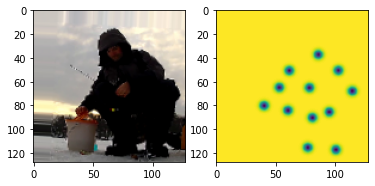

[3.73833653]


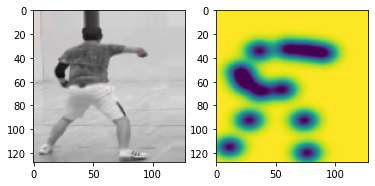

[7.54857394]


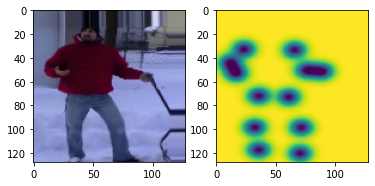

[6.77002852]


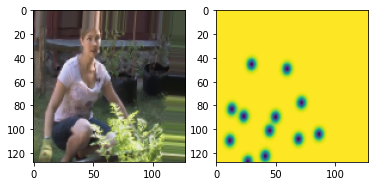

[5.10299003]


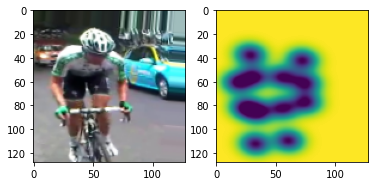

[13.51893457]


In [13]:
# for i in range(5):
#   ax = plt.subplot(1,2,1)
#   ax.imshow(cv2.cvtColor((train_images[i]*255).astype(np.uint8), cv2.COLOR_BGR2RGB))
#   ax = plt.subplot(1,2,2)
#   ax.imshow(train_heatmaps[i, ...,-1])
#   plt.show()
#   print(train_headlengths[i])


    

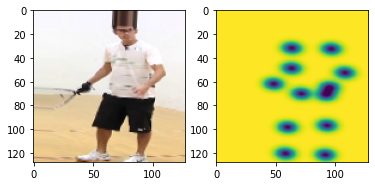

[6.26150098]


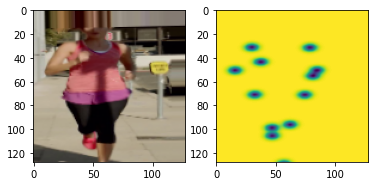

[3.78818638]


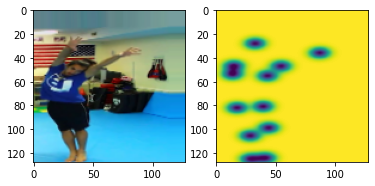

[4.80412855]


In [14]:
# for i in range(3):
#   ax = plt.subplot(1,2,1)
#   ax.imshow(cv2.cvtColor((test_images[i]*255).astype(np.uint8), cv2.COLOR_BGR2RGB))
#   ax = plt.subplot(1,2,2)
#   ax.imshow(test_heatmaps[i, ...,-1])
#   plt.show()
#   print(test_headlengths[i])


In [15]:

# np.save(os.path.join(DATASET_SAVE_PATH, "train_images.npy"), train_images)
# np.save(os.path.join(DATASET_SAVE_PATH, "train_heatmaps.npy"), train_heatmaps)
# np.save(os.path.join(DATASET_SAVE_PATH, "train_headlengths.npy"), train_headlengths)

# np.save(os.path.join(DATASET_SAVE_PATH, "test_images.npy"), test_images)
# np.save(os.path.join(DATASET_SAVE_PATH, "test_heatmaps.npy"), test_heatmaps)
# np.save(os.path.join(DATASET_SAVE_PATH, "test_headlengths.npy"), test_headlengths)


In [16]:

# # loading data

# train_images = np.load(os.path.join(DATASET_SAVE_PATH, "train_images.npy") )
# train_heatmaps = np.load(os.path.join(DATASET_SAVE_PATH, "train_heatmaps.npy"))
# train_headlengths =np.load(os.path.join(DATASET_SAVE_PATH, "train_headlengths.npy"))

# test_images = np.load(os.path.join(DATASET_SAVE_PATH, "test_images.npy"))
# test_heatmaps = np.load(os.path.join(DATASET_SAVE_PATH, "train_heatmaps.npy"))
# test_headlengths = np.load(os.path.join(DATASET_SAVE_PATH, "test_headlengths.npy"))

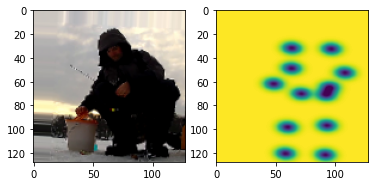

[3.73833653]


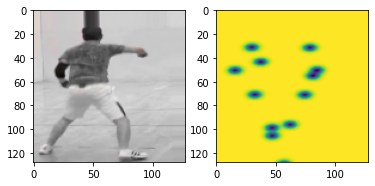

[7.54857394]


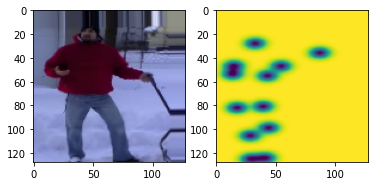

[6.77002852]


In [17]:
# for i in range(3):
#   ax = plt.subplot(1,2,1)
#   ax.imshow(cv2.cvtColor((train_images[i]*255).astype(np.uint8), cv2.COLOR_BGR2RGB))
#   ax = plt.subplot(1,2,2)
#   ax.imshow(train_heatmaps[i, ...,-1])
#   plt.show()
#   print(train_headlengths[i])


    

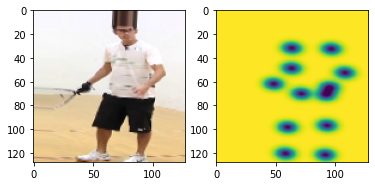

[6.26150098]


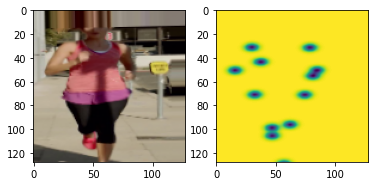

[3.78818638]


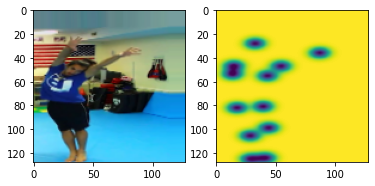

[4.80412855]


In [18]:
# for i in range(3):
#   ax = plt.subplot(1,2,1)
#   ax.imshow(cv2.cvtColor((test_images[i]*255).astype(np.uint8), cv2.COLOR_BGR2RGB))
#   ax = plt.subplot(1,2,2)
#   ax.imshow(test_heatmaps[i, ...,-1])
#   plt.show()
#   print(test_headlengths[i])


In [ ]:
# import keras
# from keras.layers import *
# from keras.models import *
# def get_Model(in_classes = 3, out_classes = NUM_CLASSES):
  
#   ip = Input(shape = (IMAGE_SIZE, IMAGE_SIZE, in_classes))
#   temp = keras.applications.MobileNetV2(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), include_top = False, weights = "imagenet" )(ip)

#   temp = UpSampling2D(size = (2,2))(temp)
#   temp = Conv2D(filters = 64, kernel_size= (3,3), padding = "same", activation = "relu")(temp)

#   temp = UpSampling2D(size = (4,4))(temp)
#   temp = Conv2D(filters = 32, kernel_size= (3,3), padding = "same", activation = "relu")(temp)

#   temp = UpSampling2D(size = (4,4))(temp)
#   temp = Conv2D(filters = 16, kernel_size= (3,3), padding = "same", activation = "relu")(temp)
  
#   temp = Conv2D(filters = out_classes, kernel_size= (1,1), padding = "same", activation = "relu")(temp)
#   op = Conv2D(filters = out_classes, kernel_size= (1,1), padding = "same", activation = "relu")(temp)

#   return Model(inputs = ip, outputs = op)

In [19]:
# from tensorflow.keras.layers import Input, Conv2D, Dropout, BatchNormalization, Dense, MaxPooling2D, Concatenate, Cropping2D, UpSampling2D, Conv2DTranspose
# from tensorflow.keras.models import Model
# from tensorflow.keras.utils import plot_model

# def get_HourGlass(cblocks = 2 , conv_perblock = 2, dropout=0.1, batchNorm = False, ip_dim=(128,128,1),
#              center_conv=2, start_filters=32, concat = True, end_filters = 1, name = "SH"):
#     args = locals()
#     if ip_dim[0] != ip_dim[1]:
#         print("Warning: This function is tested only for images with Square shape eg. 64x64x3 or 128x128x1")
#     if 2 ** cblocks > ip_dim[1]:
#         raise ValueError("Too many CONV Blocks!")
        
#     bnorm, conv, drop, pool, deconv, upscale = [[1 for _ in range(3)] for __ in range(6)]
  
#     ipt = Input(shape = (ip_dim[0], ip_dim[1], ip_dim[2]), name = "input_layer")
#     temp = ipt
  
#     for i in range(cblocks):
#         for _ in range(conv_perblock):
#             if batchNorm:
#               temp = BatchNormalization(name = "BN_down_"+str(bnorm[0]))(temp)
#               bnorm[0]+=1
#             temp = Conv2D(kernel_size = 3, filters = start_filters * 2**i,
#                           activation = "relu", padding ="same", name = "conv_down_"+str(conv[0]))(temp)
#             conv[0]+=1
#             temp = Dropout(rate = dropout, name = "drop_down_" + str(drop[0]))(temp)
#             drop[0]+=1
    
#         temp = MaxPooling2D(pool_size =2, name = "pool_down_"+str(pool[0]))(temp)
#         pool[0]+=1
    

#     ##Encoder part (downsampling only) completed
    
#     tempModel = Model(inputs =[ipt], outputs = [temp])
#     for i in range(center_conv):
#         if batchNorm:
#           temp = BatchNormalization(name = "BN_center_"+str(bnorm[1]))(temp)
#           bnorm[1]+=1
#         temp = Conv2D(kernel_size = 3, filters = start_filters * 2**(cblocks-1),
#                       activation = "relu", padding ="same", name = "conv_center_"+str(conv[1]))(temp)
#         conv[1]+=1
#         temp = Dropout(rate = dropout, name = "drop_center_" + str(drop[1]))(temp)
#         drop[1]+=1
#     #plot_model(tempModel, to_file = "halfUnet.png", show_shapes=True)
#     #tempModel.summary()
#     for i in range(cblocks):
#         #temp = UpSampling2D(size =2, name = "pool_"+str(upscale))(temp)
#         #upscale+=1
#         #temp = Conv2DTranspose(kernel_size = (3,3), filters = start_filters * 2**(cblocks-i-1),
#         #strides = (2,2), padding = "same", activation ="relu")(temp)
#         #print(i)

#         if concat:
#             temp = Conv2D(kernel_size = (3,3), filters = start_filters * 2**(cblocks-i-1),
#                           padding = "same", activation ="relu")(temp)
#         temp = UpSampling2D(size = (2,2), interpolation = "bilinear")(temp)
#         if concat:
#             temp1 = tempModel.get_layer(name = "drop_down_"+str(drop[0] - conv_perblock*i-1)).output
#             temp = Concatenate(axis = -1)([temp, temp1])

#         for _ in range(conv_perblock):
#             if batchNorm:
#               temp = BatchNormalization(name = "BN_up_"+str(bnorm[2]))(temp)
#               bnorm[2]+=1
#             temp = Conv2D(kernel_size = 3, filters = start_filters * 2**(cblocks-i-1),
#                           activation = "relu", padding ="same", name = "conv_up_"+str(conv[2]))(temp)
#             conv[2]+=1
#             temp = Dropout(rate = dropout, name = "drop_up_" + str(drop[2]))(temp)
#             drop[2]+=1
#         #xtemp =Model(inputs = [ipt], outputs = [temp])
#         #plot_model(xtemp, to_file = "xUnet.png", show_shapes=True)

#     temp = Conv2D(kernel_size=(1,1), filters = end_filters, activation = "relu", padding = "same")(temp)  
#     temp = Conv2D(kernel_size=(1,1), filters = end_filters, activation = "relu", padding = "same")(temp)  
#     opt = Conv2D(kernel_size=(1,1), filters = end_filters, activation = "softmax", padding = "same")(temp)  

#     return Model(inputs = [ipt], outputs = [opt], name = name), args

In [20]:
# mNet,_ = get_HourGlass(ip_dim=(IMAGE_SIZE, IMAGE_SIZE, 3), end_filters = 13, start_filters=16, cblocks=2, conv_perblock=1)

# # mNet.get_layer(index = 1).trainable = False

# mNet.summary()


Model: "SH"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv_down_1 (Conv2D)            (None, 128, 128, 16) 448         input_layer[0][0]                
__________________________________________________________________________________________________
drop_down_1 (Dropout)           (None, 128, 128, 16) 0           conv_down_1[0][0]                
__________________________________________________________________________________________________
pool_down_1 (MaxPooling2D)      (None, 64, 64, 16)   0           drop_down_1[0][0]                
_________________________________________________________________________________________________

In [21]:
# import tensorflow as tf

# # custom weighted loss function (weighted categorical cross entropy)
# def weighted_crossentropy(y_true, y_pred):
#   EPSILON = 0.0001

#   y_t = tf.math.multiply(tf.broadcast_to(tf.constant([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.5], dtype = float), tf.shape(y_true)) , y_true)
#   h_t = tf.math.multiply(tf.broadcast_to(tf.constant([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.5], dtype = float), tf.shape(y_pred)) , y_pred)

#   return tf.math.reduce_mean(- tf.math.multiply(y_t  , tf.math.log(tf.add(h_t, EPSILON))))

In [22]:
# from keras.optimizers import RMSprop

# mNet.compile(optimizer= "adam", loss = weighted_crossentropy)

In [53]:
# for i in range(train_heatmaps.shape[-1]):
#   plt.imshow(train_heatmaps[0, ..., i]*255)
#   plt.show()

In [23]:
# from keras.callbacks import *

# callbacks = [
#              EarlyStopping(monitor= "val_loss", patience = 100, restore_best_weights= True),
#              ReduceLROnPlateau(monitor="val_loss", patience=40)
# ]

In [ ]:
# history = mNet.fit(train_images, train_heatmaps, epochs = 1000, validation_split=0.1, callbacks=callbacks, verbose=1)

In [25]:
# train_images.shape

(632, 128, 128, 3)

In [26]:
# train_heatmaps.shape

(160, 128, 128, 13)

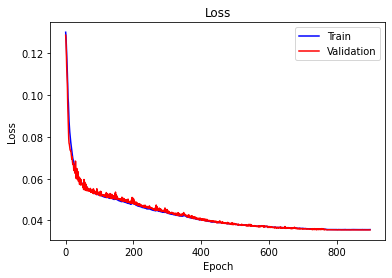

In [139]:
# # Defining a function for plotting training and validation learning curves
# def plot_history(history):
# 	  # plot loss
#     plt.title('Loss')
#     plt.plot(history.history['loss'], color='blue', label='train')
#     plt.plot(history.history['val_loss'], color='red', label='test')
#     plt.ylabel('Loss')
#     plt.xlabel('Epoch')
#     plt.legend(['Train', 'Validation'])
#     plt.show()
    
#     # # plot accuracy
#     # plt.title('Accuracy')
#     # plt.plot(history.history['accuracy'], color='blue', label='train')
#     # plt.plot(history.history['val_accuracy'], color='red', label='test')
#     # plt.ylabel('Accuracy')
#     # plt.xlabel('Epoch')
#     # plt.legend(['Train', 'Validation'])
#     # plt.show()
  
# plot_history(history)

(64, 128, 128, 13)
(64, 128, 128, 13)


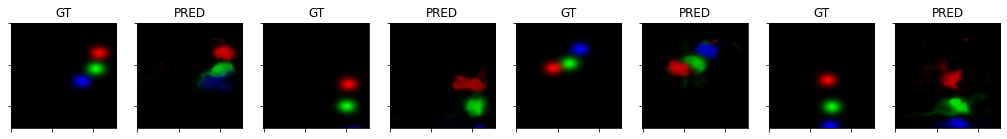

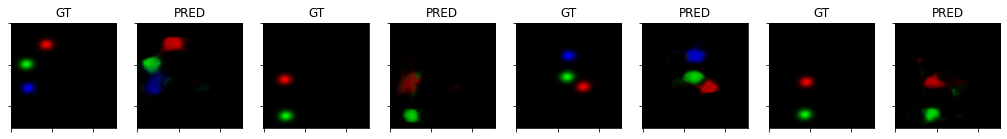

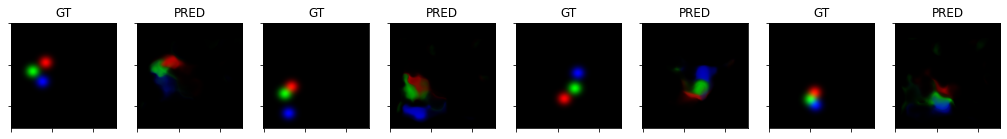

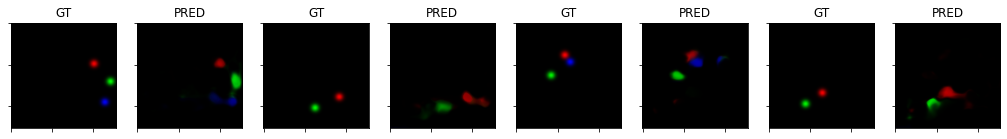

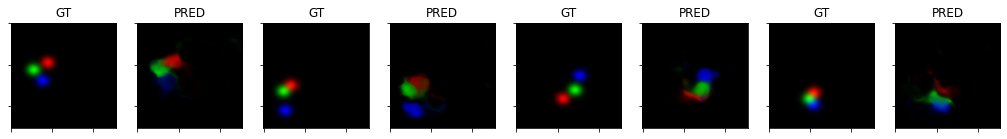

In [140]:
# NUMBER_SAMPLES = 5

# pred_heatmaps = mNet.predict(train_images)
# gt_heatmaps = train_heatmaps[:]

# print(pred_heatmaps.shape)
# print(gt_heatmaps.shape)

# imgs = train_images[:]


# for i in range(NUMBER_SAMPLES):
#   plt.figure(figsize=(20,5))

#   indx = random.randint(0, imgs.shape[0]-1)

#   # ax= plt.subplot(1, 9, 1)  
#   # ax.set_title("Image")
#   # ax.set_xticklabels([])
#   # ax.set_yticklabels([])
#   # # temp = ((imgs[indx]+1)/2) 
#   # # rgb_img_for_display = cv2.cvtColor((255*temp).astype(np.uint8), cv2.COLOR_BGR2RGB)
#   # ax.imshow(imgs[indx])

#   ax= plt.subplot(1, 9, 2)  
#   ax.set_title("GT")
#   ax.set_xticklabels([])
#   ax.set_yticklabels([])
  
#   ax.imshow(cv2.cvtColor((gt_heatmaps[indx, ..., :3]*255).astype(np.uint8), cv2.COLOR_BGR2RGB))

#   ax= plt.subplot(1, 9, 3)  
#   ax.set_title("PRED")
#   ax.set_xticklabels([])
#   ax.set_yticklabels([])

#   # temp = pred_heatmaps[indx] 
#   # rgb_img_for_display = cv2.cvtColor((255*temp).astype(np.uint8), cv2.COLOR_BGR2RGB)
  
#   ax.imshow(cv2.cvtColor((pred_heatmaps[indx, ..., :3]*255).astype(np.uint8), cv2.COLOR_BGR2RGB))

#   ax= plt.subplot(1, 9, 4)  
#   ax.set_title("GT")
#   ax.set_xticklabels([])
#   ax.set_yticklabels([])
#   ax.imshow((gt_heatmaps[indx, ..., 3:6]*255).astype(np.uint8))

#   ax= plt.subplot(1, 9, 5)  
#   ax.set_title("PRED")
#   ax.set_xticklabels([])
#   ax.set_yticklabels([])
#   ax.imshow((pred_heatmaps[indx, ..., 3:6]*255).astype(np.uint8))

#   ax= plt.subplot(1, 9, 6)  
#   ax.set_title("GT")
#   ax.set_xticklabels([])
#   ax.set_yticklabels([])
#   ax.imshow((gt_heatmaps[indx, ..., 6:9]*255).astype(np.uint8))

#   ax= plt.subplot(1, 9, 7)  
#   ax.set_title("PRED")
#   ax.set_xticklabels([])
#   ax.set_yticklabels([])
#   ax.imshow((pred_heatmaps[indx, ..., 6:9]*255).astype(np.uint8))

#   ax= plt.subplot(1, 9, 8)  
#   ax.set_title("GT")
#   ax.set_xticklabels([])
#   ax.set_yticklabels([])
#   ax.imshow((gt_heatmaps[indx, ..., 9:12]*255).astype(np.uint8))

#   ax= plt.subplot(1, 9, 9)  
#   ax.set_title("PRED")
#   ax.set_xticklabels([])
#   ax.set_yticklabels([])
#   ax.imshow((pred_heatmaps[indx, ..., 9:12]*255).astype(np.uint8))

#   plt.show()




(16, 128, 128, 13)
(16, 128, 128, 13)


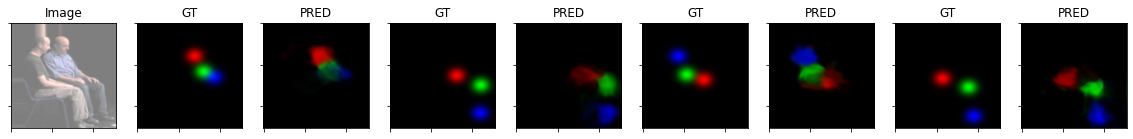

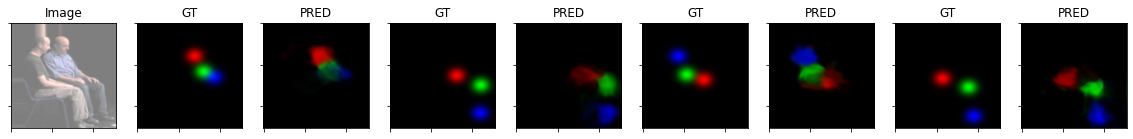

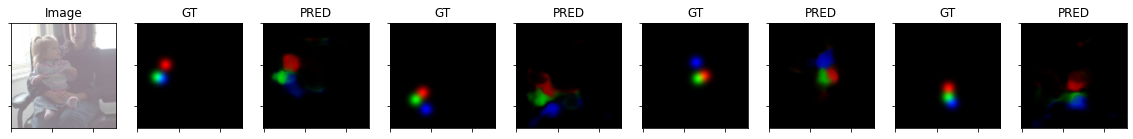

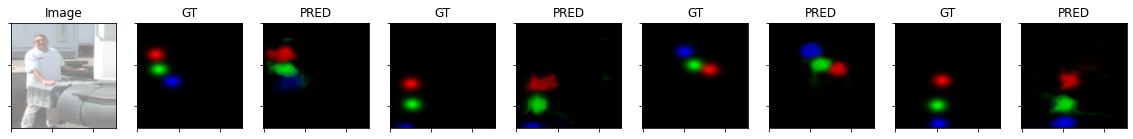

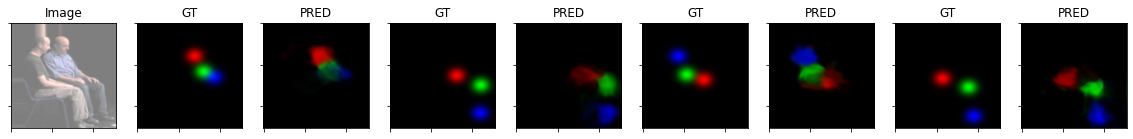

In [141]:
# NUMBER_SAMPLES = 5

# pred_heatmaps = mNet.predict(test_images)
# gt_heatmaps = test_heatmaps[:]

# print(pred_heatmaps.shape)
# print(gt_heatmaps.shape)

# imgs = test_images[:]


# for i in range(NUMBER_SAMPLES):
#   plt.figure(figsize=(20,5))

#   indx = random.randint(0, imgs.shape[0]-1)

#   ax= plt.subplot(1, 9, 1)  
#   ax.set_title("Image")
#   ax.set_xticklabels([])
#   ax.set_yticklabels([])
#   temp = ((imgs[indx]+1)/2) 
#   rgb_img_for_display = cv2.cvtColor((255*temp).astype(np.uint8), cv2.COLOR_BGR2RGB)
#   ax.imshow(rgb_img_for_display)

#   ax= plt.subplot(1, 9, 2)  
#   ax.set_title("GT")
#   ax.set_xticklabels([])
#   ax.set_yticklabels([])
  
#   ax.imshow(cv2.cvtColor((gt_heatmaps[indx, ..., :3]*255).astype(np.uint8), cv2.COLOR_BGR2RGB))

#   ax= plt.subplot(1, 9, 3)  
#   ax.set_title("PRED")
#   ax.set_xticklabels([])
#   ax.set_yticklabels([])

#   # temp = pred_heatmaps[indx] 
#   # rgb_img_for_display = cv2.cvtColor((255*temp).astype(np.uint8), cv2.COLOR_BGR2RGB)
  
#   ax.imshow(cv2.cvtColor((pred_heatmaps[indx, ..., :3]*255).astype(np.uint8), cv2.COLOR_BGR2RGB))

#   ax= plt.subplot(1, 9, 4)  
#   ax.set_title("GT")
#   ax.set_xticklabels([])
#   ax.set_yticklabels([])
#   ax.imshow((gt_heatmaps[indx, ..., 3:6]*255).astype(np.uint8))

#   ax= plt.subplot(1, 9, 5)  
#   ax.set_title("PRED")
#   ax.set_xticklabels([])
#   ax.set_yticklabels([])
#   ax.imshow((pred_heatmaps[indx, ..., 3:6]*255).astype(np.uint8))

#   ax= plt.subplot(1, 9, 6)  
#   ax.set_title("GT")
#   ax.set_xticklabels([])
#   ax.set_yticklabels([])
#   ax.imshow((gt_heatmaps[indx, ..., 6:9]*255).astype(np.uint8))

#   ax= plt.subplot(1, 9, 7)  
#   ax.set_title("PRED")
#   ax.set_xticklabels([])
#   ax.set_yticklabels([])
#   ax.imshow((pred_heatmaps[indx, ..., 6:9]*255).astype(np.uint8))

#   ax= plt.subplot(1, 9, 8)  
#   ax.set_title("GT")
#   ax.set_xticklabels([])
#   ax.set_yticklabels([])
#   ax.imshow((gt_heatmaps[indx, ..., 9:12]*255).astype(np.uint8))

#   ax= plt.subplot(1, 9, 9)  
#   ax.set_title("PRED")
#   ax.set_xticklabels([])
#   ax.set_yticklabels([])
#   ax.imshow((pred_heatmaps[indx, ..., 9:12]*255).astype(np.uint8))

#   plt.show()


